# 🚀🤖 **Lunar Lander - Reinforcement Learning with DQN**

In this notebook, we will dive into deep RL and explore ways to solve OpenAI Gym’s Lunar Lander v2 problem with Deep Q-Learning variants. ⭐


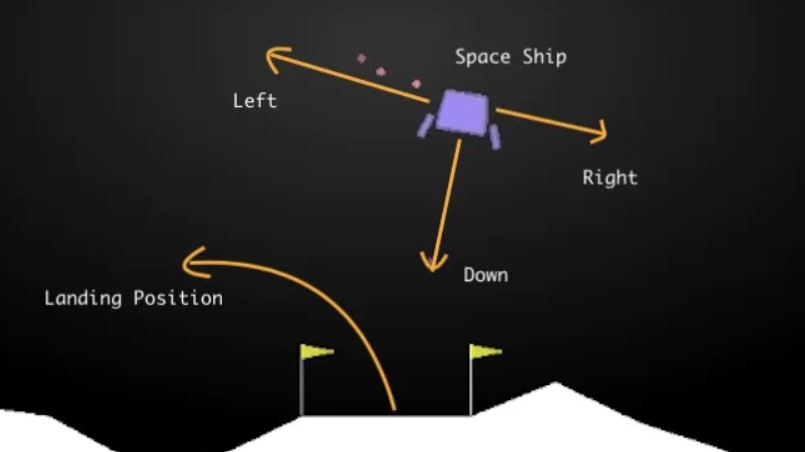


## **Description of Environment**
This environment is a classic rocket trajectory optimization problem. According to Pontryagin’s maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off.

There are two environment versions: discrete or continuous. The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector. Landing outside of the landing pad is possible. Fuel is infinite, so an agent could learn to fly and then land on its first attempt.

## **Action Space**
There are four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

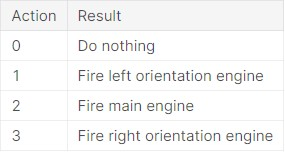

## **Observation Space**
The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.


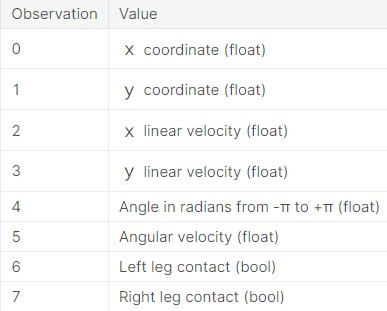

## **Rewards**
Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points. If the lander moves away from the landing pad, it loses reward. If the lander crashes, it receives an additional -100 points. If it comes to rest, it receives an additional +100 points. Each leg with ground contact is +10 points. Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame. Solved is 200 points.

## **Starting State**
The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

## **Episode Termination**
The episode finishes if:

*   The lander crashes (the lander body gets in contact with the moon);
*   The lander gets outside of the viewport (x coordinate is greater than 1);
*   The lander is not awake. From the Box2D docs, a body which is not awake is a body which doesn’t move and doesn’t collide with any other body.


## **Setup**

### Install dependencies

In [2]:
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install -y swig build-essential python-dev python3-dev > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1
!apt-get install xvfb > /dev/null 2>&1

In [3]:
!pip install gym==0.25.2
!pip install rarfile --quiet
!pip install stable-baselines3[extra] --quiet
!pip install ale-py --quiet
!pip install gym[box2d] --quiet
!pip install pyvirtualdisplay --quiet
!pip install pyglet --quiet
!pip install pygame --quiet
!pip install minigrid --quiet
!pip install -q swig --quiet
!pip install -q gymnasium[box2d] --quiet
!pip install 'minigrid<=2.1.1' --quiet
!pip3 install box2d-py --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 56.8 MB/s eta 0:00:00


### Importations

In [4]:
import random
import sys
from time import time
from collections import deque, defaultdict, namedtuple
import numpy as np
import pandas as pd
import gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

<ipython-input-4-e8c810993f1c>:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Gym Environment

Create gym environment, explore its state and and action space, play with random agent.

In [5]:
env = gym.make('LunarLander-v2')
env.seed(0)

# inspect action space and state space
print(env.action_space)
print(env.observation_space.shape[0])
print("******")
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)
print("\n")

Discrete(4)
8
******
State shape:  (8,)
Number of actions:  4




/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [6]:
print(env.observation_space, env.action_space)

print(env.observation_space.sample())

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32) Discrete(4)
[-0.6105359  -0.4002158  -4.5662203  -3.655748   -3.0035965  -0.99645036
  0.8203038   0.51236653]


From Gym Docs: The Discrete space allows a fixed range of non-negative numbers, so in this case valid actions are either 0 or 1. The Box space represents an n-dimensional box, so valid observations will be an array of 4 numbers.

In [7]:
# agent that takes random actions
max_episodes = 100
scores = []
actions = range(env.action_space.n)
for i in range(1, max_episodes+1):
    state = env.reset()
    score = 0
    while True:
        action = np.random.choice(actions)
        state, reward, done, info = env.step(action)
        score += reward
        if done:
            if i % 20 == 0:
                print('Episode {},  score: {}'.format(i, score))
            break

    scores.append(score)

Episode 20,  score: -148.89504129990655
Episode 40,  score: -203.39212855517263
Episode 60,  score: -297.224748443511
Episode 80,  score: -206.5919157477502
Episode 100,  score: -60.935745040257416


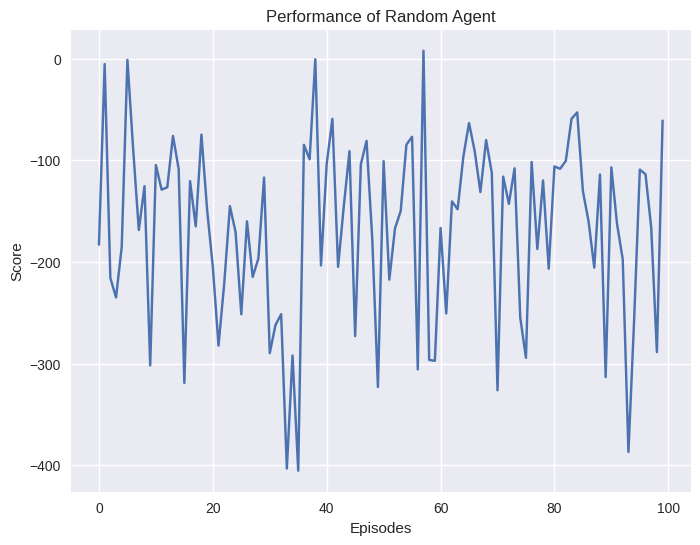

In [8]:
# show random agent's performance
plt.figure(figsize=(8,6))
plt.plot(range(max_episodes), scores)
plt.title('Performance of Random Agent')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.show()

In [9]:
# average score
print('Average score of random agent over {} episodes: {:.2f}'.format(max_episodes, np.mean(scores)))

Average score of random agent over 100 episodes: -167.21


## **Deep Q Network (DQN)**

It's time to implement the DQN algorithm.


Now, let's break down the implementation into following components, all of these will ideally be in python files (.py) but since I am using notebook I have added here to show the entire implementation.

*   DQNAgent
*   QNewtork
*   ReplayMemory

In [10]:
# use cuda if available else use cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Q Network
Fully connected neural network (Q Network) implemetation in awesome pytorch.

In [11]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        """
        Build a fully connected neural network

        Parameters
        ----------
        state_size (int): State dimension
        action_size (int): Action dimension
        seed (int): random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        """Forward pass"""
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

### Replay Memory

In [12]:
class ReplayMemory:
    def __init__(self, buffer_size, batch_size, seed):
        """
        Replay memory allow agent to record experiences and learn from them

        Parametes
        ---------
        buffer_size (int): maximum size of internal memory
        batch_size (int): sample size from experience
        seed (int): random seed
        """
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """Add experience"""
        experience = self.experience(state, action, reward, next_state, done)
        self.memory.append(experience)

    def sample(self):
        """
        Sample randomly and return (state, action, reward, next_state, done) tuple as torch tensors
        """
        experiences = random.sample(self.memory, k=self.batch_size)

        # convert to torch tensors
        states = torch.from_numpy(np.vstack([experience.state for experience in experiences if experience is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([experience.action for experience in experiences if experience is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([experience.reward for experience in experiences if experience is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([experience.next_state for experience in experiences if experience is not None])).float().to(device)
        # convert done from boolean to int
        dones = torch.from_numpy(np.vstack([experience.done for experience in experiences if experience is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

### Agent

In [13]:
BUFFER_SIZE = int(1e5) # replay memory size
BATCH_SIZE = 64         # number of experiences to sample from memory
GAMMA = 0.99            # discount factor
TAU = 1e-3              # soft update parameter for updating target q network
LR = 1e-4               # Q Network learning rate
UPDATE_EVERY = 4        # how often to update Q network

In [14]:
class DQNAgent:
    def __init__(self, state_size, action_size, seed):
        """
        DQN Agent interacts with the environment,
        stores the experience and learns from it

        Parameters
        ----------
        state_size (int): Dimension of state
        action_size (int): Dimension of action
        seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        # initialize Q and Target Q networks
        self.q_network = QNetwork(state_size, action_size, seed).to(device)
        self.target_network = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters())
        # initiliase memory
        self.memory = ReplayMemory(BUFFER_SIZE, BATCH_SIZE, seed)
        self.timestep = 0


    def step(self, state, action, reward, next_state, done):
        """
        Update Agent's knowledge

        Parameters
        ----------
        state (array_like): Current state of environment
        action (int): Action taken in current state
        reward (float): Reward received after taking action
        next_state (array_like): Next state returned by the environment after taking action
        done (bool): whether the episode ended after taking action
        """
        self.memory.add(state, action, reward, next_state, done)
        self.timestep += 1
        if self.timestep % UPDATE_EVERY == 0:
            if len(self.memory) > BATCH_SIZE:
                sampled_experiences = self.memory.sample()
                self.learn(sampled_experiences)

    def learn(self, experiences):
        """
        Learn from experience by training the q_network

        Parameters
        ----------
        experiences (array_like): List of experiences sampled from agent's memory
        """
        states, actions, rewards, next_states, dones = experiences
        # get the action with max Q value
        action_values = self.target_network(next_states).detach()

        # tensor.max(1)[0] returns the values, tensor.max(1)[1] will return indices
        # unsqueeze operation --> np.reshape
        # here, we make it from torch.Size([64]) -> torch.Size([64, 1])
        max_action_values = action_values.max(1)[0].unsqueeze(1)

        # if done just use reward, else update Q_target with discounted action values
        Q_target = rewards + (GAMMA * max_action_values * (1 - dones))
        Q_expected = self.q_network(states).gather(1, actions)

        # calculate loss
        loss = F.mse_loss(Q_expected, Q_target)
        self.optimizer.zero_grad()
        # backward pass
        loss.backward()
        # update weights
        self.optimizer.step()

        # update target weights
        self.update_target_network(self.q_network, self.target_network)

    def update_target_network(self, q_network, target_network):
        """
        Update target network by copying weights from Q network using TAU param

        Parameters
        ----------
        q_network (PyTorch model): Q network
        target_network (PyTorch model): Fixed target network
        """
        for source_parameters, target_parameters in zip(q_network.parameters(), target_network.parameters()):
            target_parameters.data.copy_(TAU * source_parameters.data + (1.0 - TAU) * target_parameters.data)


    def act(self, state, eps=0.0):
        """
        Choose the action

        Parameters
        ----------
        state (array_like): current state of environment
        eps (float): epsilon for epsilon-greedy action selection
        """
        rnd = random.random()
        if rnd < eps:
            return np.random.randint(self.action_size)
        else:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            # set the network into evaluation mode
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            # back to training mode
            self.q_network.train()
            action = np.argmax(action_values.cpu().data.numpy())
            return action

    def checkpoint(self, filename):
        torch.save(self.q_network.state_dict(), filename)

### Training
With all the components in place, we can start training out the agent.

In [15]:
MAX_EPISODES = 2000  # max number of episodes to play
MAX_STEPS = 1000     # max steps allowed in a single episode/play
ENV_SOLVED = 200     # max score at which we consider environment to be solved
PRINT_EVERY = 100    # how often to print the progress

# epsilon schedule
EPS_START = 1.0      # starting value of eps
EPS_DECAY = 0.999    # epsilon decay rate
EPS_MIN = 0.01       # min epsilon


Let's visualize the effect of different decay rate values ​​(EPS_DECAY_RATES) on the evolution of the exploration probability (epsilon) of the agent over the learning episodes.

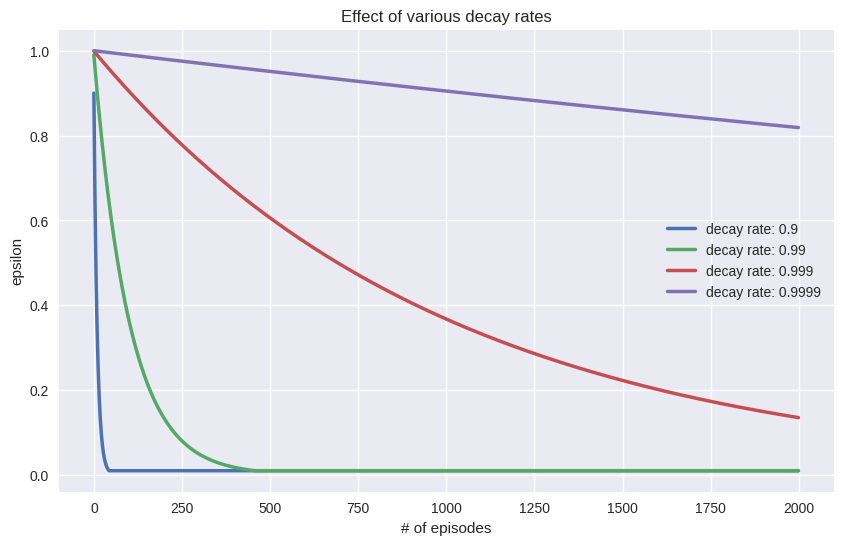

In [16]:
EPS_DECAY_RATES = [0.9, 0.99, 0.999, 0.9999]
plt.figure(figsize=(10,6))

for decay_rate in EPS_DECAY_RATES:
    test_eps = EPS_START
    eps_list = []
    for _ in range(MAX_EPISODES):
        test_eps = max(test_eps * decay_rate, EPS_MIN)
        eps_list.append(test_eps)

    plt.plot(eps_list, label='decay rate: {}'.format(decay_rate), linewidth=2.5)

plt.title('Effect of various decay rates')
plt.legend(loc='best')
plt.xlabel('# of episodes')
plt.ylabel('epsilon')
plt.show()

In [17]:
# check state and action sizes
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print('State size: {}, Action size: {}'.format(state_size, action_size))

State size: 8, Action size: 4


In [18]:
dqn_agent = DQNAgent(state_size, action_size, seed=0)
start = time()
scores = []
# make a list of last 100 scores
scores_window = deque(maxlen=100)
eps = EPS_START
for episode in range(1, MAX_EPISODES + 1):
    state = env.reset()
    score = 0
    for t in range(MAX_STEPS):
        action = dqn_agent.act(state, eps)
        next_state, reward, done, info = env.step(action)
        dqn_agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break

        eps = max(eps * EPS_DECAY, EPS_MIN)
        if episode % PRINT_EVERY == 0:
            mean_score = np.mean(scores_window)
            print('\rProgress {}/{}, average score:{:.2f}'.format(episode, MAX_EPISODES, mean_score), end="")
        if score >= ENV_SOLVED:
            mean_score = np.mean(scores_window)
            print('\rEnvironment solved in {} episodes, average score: {:.2f}'.format(episode, mean_score), end="")
            sys.stdout.flush()
            dqn_agent.checkpoint('checkpoint.pth')
            break

    scores_window.append(score)
    scores.append(score)

end = time()
print('Took {} seconds'.format(end - start))

Progress 2000/2000, average score:240.65Took 2912.0093750953674 seconds


In [19]:
dqn_agent.checkpoint('checkpoint.pth')

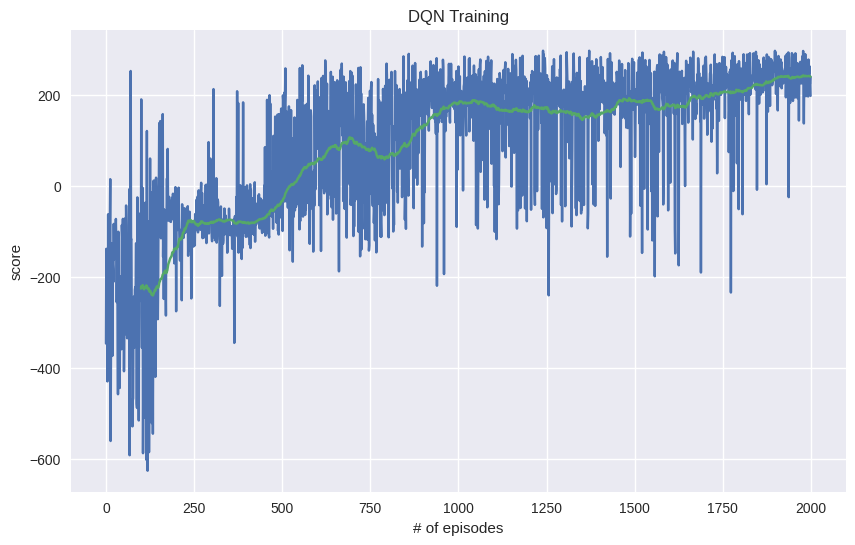

In [20]:
plt.figure(figsize=(10,6))
plt.plot(scores)
plt.plot(pd.Series(scores).rolling(100).mean())
plt.title('DQN Training')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.show()

## **Play**

In [21]:
dqn_agent.q_network.load_state_dict(torch.load('checkpoint.pth'))

<All keys matched successfully>

In [29]:
import os
import gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder

env = gym.make('LunarLander-v2')
env.seed(0)

# define the directory for video recording
video_dir = '/content/lunar-lander-videos/'  # Change the path to your desired directory

# create the directory if it doesn't exist
os.makedirs(video_dir, exist_ok=True)

for i in range(5):
    score = 0
    state = env.reset()

    # create a VideoRecorder for each episode
    video_path = os.path.join(video_dir, f'episode_{i}.mp4')
    video_recorder = VideoRecorder(env, video_path)

    while True:
        action = dqn_agent.act(state)
        next_state, reward, done, info = env.step(action)
        state = next_state
        score += reward

        # capture frames for the video
        video_recorder.capture_frame()

        if done:
            video_recorder.close()  # save the recorded video for this episode
            break

    print(f'Episode {i}: Scored {score}')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized

Episode 0: Scored 287.85573227302143


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Episode 1: Scored 225.39749616079018


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Episode 2: Scored 232.6487215331584


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Episode 3: Scored 264.8417059133078


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Episode 4: Scored 298.2175473039689


In [ ]:
env.close()